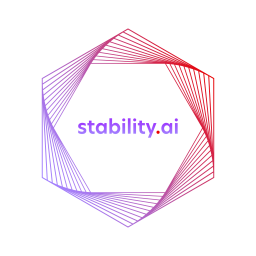

Model by RiversHaveWings [https://twitter.com/RiversHaveWings]

Notebook by nshepperd [https://twitter.com/nshepperd1]

Sponsored by StabilityAI [https://twitter.com/stabilityai]

# Stable Diffusion Upscaler Demo

Usage:

1. Run installation. On the first run this requires restarting the runtime, because we need to upgrade PIL/Pillow, which is imported by colab internally.
2. Prepare and download models. Check the checkbox in cell 2b if you want your samples saved on google drive (by default they are not, just displayed at the output cell).
3. Configure and run the model. A prompt is not really necessary but does subtly affect the upscaling result. Then run cell 3b to upload an image, then 3c to run the upscaler.

In [ ]:
#@title Licensed under the MIT License { display-mode: "form" }

# Copyright (c) 2022 Emily Shepperd <nshepperd@gmail.com>

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

## 1. Installation

In [5]:
#@title Upgrade PIL first
#@markdown Colab imports PIL itself, which means we need to restart the runtime to get the new version after updating it.
#@markdown Check if we have the old version, and if so update it first and reset the runtime.
from packaging import version
import PIL
if version.parse(PIL.__version__) < version.parse('9.3.0'):
  # !pip install -U Pillow
  print(PIL.__version__)
  exit()

In [ ]:
#@title Check GPU
!nvidia-smi

In [ ]:
#@title Install Deps
!pip install ftfy einops braceexpand requests transformers clip omegaconf pytorch-lightning kornia k-diffusion
!pip install -U git+https://github.com/huggingface/huggingface_hub

In [ ]:
!git clone https://github.com/CompVis/stable-diffusion
!git clone https://github.com/CompVis/taming-transformers
!git clone https://github.com/CompVis/latent-diffusion

In [3]:
%pip install -r ../requirements.txt

  Cloning https://github.com/huggingface/huggingface_hub to /tmp/pip-req-build-89oqyvm9
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/huggingface_hub /tmp/pip-req-build-89oqyvm9
  Resolved https://github.com/huggingface/huggingface_hub to commit 55f1bcda2b7c309cbe40711c7f4f0828ca5ae7d0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Using cached einops-0.6.1-py3-none-any.whl (42 kB)
  Using cached braceexpand-0.1.7-py2.py3-none-any.whl (5.9 kB)
  Using cached transformers-4.31.0-py3-none-any.whl (7.4 MB)
  Using cached clip-0.2.0-py3-none-any.whl
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached pytorch_lightning-2.0.6-py3-none-any.whl (722 kB)
  Using cached kornia-0.7.0-py2.py3-none-any.whl (705 kB)
  Using cached k_diffusion-0.0.16-py3-none-any.whl (25 kB)
  Using cached filelock-3.12.

## 2. Prepare

In [4]:
#@title 2a. Import libraries { display-mode: "form" }

import sys, os
sys.path.extend(['./taming-transformers', './stable-diffusion', './latent-diffusion'])

import numpy as np
import time
import re
import requests
import io
import hashlib
from subprocess import Popen

import torch
from torch import nn
import torch.nn.functional as F

from PIL import Image
from einops import rearrange
from omegaconf import OmegaConf
from pytorch_lightning import seed_everything
from torchvision.utils import make_grid
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange
from functools import partial
from IPython.display import display
from ipywidgets import widgets

from ldm.util import instantiate_from_config
import k_diffusion as K

In [5]:
#@title 2b. Save your samples to google drive (disabled by default) { display-mode: "form" }
#@markdown Save location format:
#@markdown - %T: timestamp
#@markdown - %S: seed
#@markdown - %I: image index
#@markdown - %P: prompt (will be truncated to avoid overly long filenames)
save_to_drive = False #@param {type: 'boolean'}
save_location = 'stable-diffusion-upscaler/%T-%I-%P.png' #@param {type: 'string'}

if save_to_drive:
  from google.colab import drive
  drive.mount('/content/drive')
  save_location = '/content/drive/MyDrive/' + save_location

def clean_prompt(prompt):
  badchars = re.compile(r'[/\\]')
  prompt = badchars.sub('_', prompt)
  if len(prompt) > 100:
    prompt = prompt[:100] + '…'
  return prompt

def format_filename(timestamp, seed, index, prompt):
  string = save_location
  string = string.replace('%T', f'{timestamp}')
  string = string.replace('%S', f'{seed}')
  string = string.replace('%I', f'{index:02}')
  string = string.replace('%P', clean_prompt(prompt))
  return string

def save_image(image, **kwargs):
  filename = format_filename(**kwargs)
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  image.save(filename)

In [6]:
#@title 2c. Fetch models { display-mode: "form" }
def fetch(url_or_path):
  if url_or_path.startswith('http:') or url_or_path.startswith('https:'):
    _, ext = os.path.splitext(os.path.basename(url_or_path))
    cachekey = hashlib.md5(url_or_path.encode('utf-8')).hexdigest()
    cachename = f'{cachekey}{ext}'
    if not os.path.exists(f'cache/{cachename}'):
      os.makedirs('tmp', exist_ok=True)
      os.makedirs('cache', exist_ok=True)
      !curl '{url_or_path}' -o 'tmp/{cachename}'
      os.rename(f'tmp/{cachename}', f'cache/{cachename}')
    return f'cache/{cachename}'
  return url_or_path

class NoiseLevelAndTextConditionedUpscaler(nn.Module):
    def __init__(self, inner_model, sigma_data=1., embed_dim=256):
        super().__init__()
        self.inner_model = inner_model
        self.sigma_data = sigma_data
        self.low_res_noise_embed = K.layers.FourierFeatures(1, embed_dim, std=2)

    def forward(self, input, sigma, low_res, low_res_sigma, c, **kwargs):
        cross_cond, cross_cond_padding, pooler = c
        c_in = 1 / (low_res_sigma ** 2 + self.sigma_data ** 2) ** 0.5
        c_noise = low_res_sigma.log1p()[:, None]
        c_in = K.utils.append_dims(c_in, low_res.ndim)
        low_res_noise_embed = self.low_res_noise_embed(c_noise)
        low_res_in = F.interpolate(low_res, scale_factor=2, mode='nearest') * c_in
        mapping_cond = torch.cat([low_res_noise_embed, pooler], dim=1)
        return self.inner_model(input, sigma, unet_cond=low_res_in, mapping_cond=mapping_cond, cross_cond=cross_cond, cross_cond_padding=cross_cond_padding, **kwargs)

def make_upscaler_model(config_path, model_path, pooler_dim=768, train=False, device='cpu'):
    config = K.config.load_config(open(config_path))
    model = K.config.make_model(config)
    model = NoiseLevelAndTextConditionedUpscaler(
        model,
        sigma_data=config['model']['sigma_data'],
        embed_dim=config['model']['mapping_cond_dim'] - pooler_dim,
    )
    ckpt = torch.load(model_path, map_location='cpu')
    model.load_state_dict(ckpt['model_ema'])
    model = K.config.make_denoiser_wrapper(config)(model)
    if not train:
        model = model.eval().requires_grad_(False)
    return model.to(device)

model_up = make_upscaler_model(fetch('https://models.rivershavewings.workers.dev/config_laion_text_cond_latent_upscaler_2.json'),
                               fetch('https://models.rivershavewings.workers.dev/laion_text_cond_latent_upscaler_2_1_00470000_slim.pth'))

from requests.exceptions import HTTPError
import huggingface_hub

def download_from_huggingface(repo, filename):
  while True:
    try:
      return huggingface_hub.hf_hub_download(repo, filename)
    except HTTPError as e:
      if e.response.status_code == 401:
        # Need to log into huggingface api
        huggingface_hub.interpreter_login()
        continue
      elif e.response.status_code == 403:
        # Need to do the click through license thing
        print(f'Go here and agree to the click through license on your account: https://huggingface.co/{repo}')
        input('Hit enter when ready:')
        continue
      else:
        raise e

# sd_model_path = download_from_huggingface("CompVis/stable-diffusion-v-1-4-original", "sd-v1-4.ckpt")
vae_840k_model_path = download_from_huggingface("stabilityai/sd-vae-ft-mse-original", "vae-ft-mse-840000-ema-pruned.ckpt")
vae_560k_model_path = download_from_huggingface("stabilityai/sd-vae-ft-ema-original", "vae-ft-ema-560000-ema-pruned.ckpt")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1294  100  1294    0     0   1043      0  0:00:01  0:00:01 --:--:--  1044
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1421M  100 1421M    0     0  27.2M      0  0:00:52  0:00:52 --:--:-- 28.6M913M    0     0  26.5M      0  0:00:53  0:00:34  0:00:19 24.7M


In [7]:
#@title Load models on GPU { display-mode: "form" }

cpu = torch.device("cpu")
device = torch.device("cuda")

def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    config = OmegaConf.load(config)
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model = model.to(cpu).eval().requires_grad_(False)
    return model

# sd_model = load_model_from_config("stable-diffusion/configs/stable-diffusion/v1-inference.yaml", sd_model_path)
vae_model_840k = load_model_from_config("latent-diffusion/models/first_stage_models/kl-f8/config.yaml", vae_840k_model_path)
vae_model_560k = load_model_from_config("latent-diffusion/models/first_stage_models/kl-f8/config.yaml", vae_560k_model_path)

# sd_model = sd_model.to(device)
vae_model_840k = vae_model_840k.to(device)
vae_model_560k = vae_model_560k.to(device)
model_up = model_up.to(device)

Loading model from /home/azureuser/.cache/huggingface/hub/models--stabilityai--sd-vae-ft-mse-original/snapshots/629b3ad3030ce36e15e70c5db7d91df0d60c627f/vae-ft-mse-840000-ema-pruned.ckpt
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/anaconda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/azureuser/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 349MB/s] 


8.19kB [00:00, 44.6kB/s]                            


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Loading model from /home/azureuser/.cache/huggingface/hub/models--stabilityai--sd-vae-ft-ema-original/snapshots/e21db4dc8d4f2675c2ffef479c4c893e83bceada/vae-ft-ema-560000-ema-pruned.ckpt
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [8]:
#@title Set up some functions and load the text encoder { display-mode: "form" }

class CFGUpscaler(nn.Module):
    def __init__(self, model, uc, cond_scale):
        super().__init__()
        self.inner_model = model
        self.uc = uc
        self.cond_scale = cond_scale

    def forward(self, x, sigma, low_res, low_res_sigma, c):
        if self.cond_scale in (0.0, 1.0):
          # Shortcut for when we don't need to run both.
          if self.cond_scale == 0.0:
            c_in = self.uc
          elif self.cond_scale == 1.0:
            c_in = c
          return self.inner_model(x, sigma, low_res=low_res, low_res_sigma=low_res_sigma, c=c_in)

        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        low_res_in = torch.cat([low_res] * 2)
        low_res_sigma_in = torch.cat([low_res_sigma] * 2)
        c_in = [torch.cat([uc_item, c_item]) for uc_item, c_item in zip(self.uc, c)]
        uncond, cond = self.inner_model(x_in, sigma_in, low_res=low_res_in, low_res_sigma=low_res_sigma_in, c=c_in).chunk(2)
        return uncond + (cond - uncond) * self.cond_scale


class CLIPTokenizerTransform:
    def __init__(self, version="openai/clip-vit-large-patch14", max_length=77):
        from transformers import CLIPTokenizer
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        self.max_length = max_length

    def __call__(self, text):
        indexer = 0 if isinstance(text, str) else ...
        tok_out = self.tokenizer(text, truncation=True, max_length=self.max_length,
                                 return_length=True, return_overflowing_tokens=False,
                                 padding='max_length', return_tensors='pt')
        input_ids = tok_out['input_ids'][indexer]
        attention_mask = 1 - tok_out['attention_mask'][indexer]
        return input_ids, attention_mask


class CLIPEmbedder(nn.Module):
    """Uses the CLIP transformer encoder for text (from Hugging Face)"""
    def __init__(self, version="openai/clip-vit-large-patch14", device="cuda"):
        super().__init__()
        from transformers import CLIPTextModel, logging
        logging.set_verbosity_error()
        self.transformer = CLIPTextModel.from_pretrained(version)
        self.transformer = self.transformer.eval().requires_grad_(False).to(device)

    @property
    def device(self):
        return self.transformer.device

    def forward(self, tok_out):
        input_ids, cross_cond_padding = tok_out
        clip_out = self.transformer(input_ids=input_ids.to(self.device), output_hidden_states=True)
        return clip_out.hidden_states[-1], cross_cond_padding.to(self.device), clip_out.pooler_output

tok_up = CLIPTokenizerTransform()
text_encoder_up = CLIPEmbedder(device=device)


## 3. Configure and Run

In [13]:
#@title 3a. Configuration { display-mode: "form" }
#@markdown Prompt. Not strictly required but can subtly affect the upscaling result.
prompt = "the temple of fire by Ross Tran and Gerardo Dottori, oil on canvas" #@param {type: 'string'}
prompt = "beautiful japanese girl" #@param {type: 'string'}
# input_file = "https://cdn.discordapp.com/attachments/947643942298595401/1036567210191245402/unknown.png" #@param {type:'string'}
num_samples = 1 #@param {type: 'integer'}
batch_size = 1 #@param {type: 'integer'}

decoder = 'finetuned_840k' #@param ["finetuned_840k", "finetuned_560k"]

guidance_scale = 1 #@param {type: 'slider', min: 0.0, max: 10.0, step:0.5}

#@markdown Add noise to the latent vectors before upscaling. This theoretically can make the model work better on out-of-distribution inputs, but mostly just seems to make it match the input less, so it's turned off by default.
noise_aug_level = 0 #@param {type: 'slider', min: 0.0, max: 0.6, step:0.025}
noise_aug_type = 'gaussian' #@param ["gaussian", "fake"]

#@markdown ---

#@markdown Sampler settings. `k_dpm_adaptive` uses an adaptive solver with error tolerance `tol_scale`, all other use a fixed number of steps.
sampler = 'k_dpm_adaptive' #@param ["k_euler", "k_euler_ancestral", "k_dpm_2_ancestral", "k_dpm_fast", "k_dpm_adaptive"]
steps = 50 #@param {type: 'integer'}
tol_scale = 0.25 #@param {type: 'number'}
#@markdown Amount of noise to add per step (0.0=deterministic). Used in all samplers except `k_euler`.
eta = 1.0 #@param {type: 'number'}

#@markdown Set seed to 0 to use the current time:
seed = 0 #@param {type: 'integer'}

In [14]:
#@title 3b. Upload image for upscaling. { display-mode: "form" }
#@markdown Run this cell and then upload your image here. You should do
#@markdown this before running the next cell. Note that
#@markdown both of the image's dimensions need to be a multiple of 64.
#@markdown This works best on images generated by stable diffusion.
if 'input_image' not in globals():
  # Set a demo image on first run.
  input_image = Image.open(fetch('https://models.rivershavewings.workers.dev/assets/sd_2x_upscaler_demo.png')).convert('RGB')

def pil_to_bytes(image):
  with io.BytesIO() as fp:
    image.save(fp, format='png')
    return fp.getvalue()

def on_upload(change):
  global input_image
  if change['name'] == 'value':
    value ,= change['new'].values()
    filename = value['metadata']['name']
    assert '/' not in filename
    print(f'Upscaling {filename}')
    input_image = Image.open(io.BytesIO(value['content'])).convert('RGB')
    image_widget.value = value['content']
    image_widget.width = input_image.size[0]
    image_widget.height = input_image.size[1]
upload = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False)
upload.observe(on_upload)
image_widget = widgets.Image(value=pil_to_bytes(input_image), width=512, height=512)
box = widgets.VBox([upload, image_widget])
display(box)

In [12]:
#@title 3c. Run the model { display-mode: "form" }

# Model configuration values
SD_C = 4 # Latent dimension
SD_F = 8 # Latent patch size (pixels per latent)
SD_Q = 0.18215 # sd_model.scale_factor; scaling for latents in first stage models

@torch.no_grad()
def condition_up(prompts):
  return text_encoder_up(tok_up(prompts))

@torch.no_grad()
def run(seed):
  timestamp = int(time.time())
  if not seed:
    print('No seed was provided, using the current time.')
    seed = timestamp
  print(f'Generating with seed={seed}')
  seed_everything(seed)

  uc = condition_up(batch_size * [""])
  c = condition_up(batch_size * [prompt])

  if decoder == 'finetuned_840k':
    vae = vae_model_840k
  elif decoder == 'finetuned_560k':
    vae = vae_model_560k

  # image = Image.open(fetch(input_file)).convert('RGB')
  image = input_image
  image = TF.to_tensor(image).to(device) * 2 - 1
  low_res_latent = vae.encode(image.unsqueeze(0)).sample() * SD_Q
  low_res_decoded = vae.decode(low_res_latent/SD_Q)

  [_, C, H, W] = low_res_latent.shape

  # Noise levels from stable diffusion.
  sigma_min, sigma_max = 0.029167532920837402, 14.614642143249512

  model_wrap = CFGUpscaler(model_up, uc, cond_scale=guidance_scale)
  low_res_sigma = torch.full([batch_size], noise_aug_level, device=device)
  x_shape = [batch_size, C, 2*H, 2*W]

  def do_sample(noise, extra_args):
    # We take log-linear steps in noise-level from sigma_max to sigma_min, using one of the k diffusion samplers.
    sigmas = torch.linspace(np.log(sigma_max), np.log(sigma_min), steps+1).exp().to(device)
    if sampler == 'k_euler':
      return K.sampling.sample_euler(model_wrap, noise * sigma_max, sigmas, extra_args=extra_args)
    elif sampler == 'k_euler_ancestral':
      return K.sampling.sample_euler_ancestral(model_wrap, noise * sigma_max, sigmas, extra_args=extra_args, eta=eta)
    elif sampler == 'k_dpm_2_ancestral':
      return K.sampling.sample_dpm_2_ancestral(model_wrap, noise * sigma_max, sigmas, extra_args=extra_args, eta=eta)
    elif sampler == 'k_dpm_fast':
      return K.sampling.sample_dpm_fast(model_wrap, noise * sigma_max, sigma_min, sigma_max, steps, extra_args=extra_args, eta=eta)
    elif sampler == 'k_dpm_adaptive':
      sampler_opts = dict(s_noise=1., rtol=tol_scale * 0.05, atol=tol_scale / 127.5, pcoeff=0.2, icoeff=0.4, dcoeff=0)
      return K.sampling.sample_dpm_adaptive(model_wrap, noise * sigma_max, sigma_min, sigma_max, extra_args=extra_args, eta=eta, **sampler_opts)

  image_id = 0
  for _ in range((num_samples-1)//batch_size + 1):
    if noise_aug_type == 'gaussian':
      latent_noised = low_res_latent + noise_aug_level * torch.randn_like(low_res_latent)
    elif noise_aug_type == 'fake':
      latent_noised = low_res_latent * (noise_aug_level ** 2 + 1)**0.5
    extra_args = {'low_res': latent_noised, 'low_res_sigma': low_res_sigma, 'c': c}
    noise = torch.randn(x_shape, device=device)
    up_latents = do_sample(noise, extra_args)

    pixels = vae.decode(up_latents/SD_Q) # equivalent to sd_model.decode_first_stage(up_latents)
    pixels = pixels.add(1).div(2).clamp(0,1)


    # Display and save samples.
    display(TF.to_pil_image(make_grid(pixels, batch_size)))
    for j in range(pixels.shape[0]):
      img = TF.to_pil_image(pixels[j])
      save_image(img, timestamp=timestamp, index=image_id, prompt=prompt, seed=seed)
      image_id += 1

run(seed)

Global seed set to 1692084354


No seed was provided, using the current time.
Generating with seed=1692084354


0it [00:00, ?it/s]

RuntimeError: Expected attn_mask dtype to be bool or to match query dtype, but got attn_mask.dtype: long int and  query.dtype: float instead.

In [15]:
%pip install black

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
